# Introduction (5 Points)

As climate change becomes a more prominant issue, the spread of wildfires become more prominent. The number of acres burned and the quantity of wildfires per year has increased steadily over the past couple years. It becomes important to predict these wildfires based on weather and other charecteristics to prevent the wildfire from happening in general. Conversly, it becomes important to predict the area that the wildfire might spread to prevent caualties and provide the necessary support equipment. Predicting the fire size and intensity will allow for proper deployment of the fire departments to contain the fire. This project will focus on the latter, predicting wildfire size and intensity to allow for safe evacuation and containment prior to spreading to populated location. Essentially, we break this up into a two part problem. The first problem is to try and fit a regression model that takes charecteristics of a wildfire to predict its size that burned in acres. This model can be improved using decision trees and tuning techniques. We can apply this to new test data to predict the accuracy of the model. We will be looking at two types of datasets to predict the burned area regression model. The first dataset is from California and it has attributes on location, number of tankers used, fire temperature, nearby fire stations, and more fire fighting features. The dataset was acquired from California.gov website. There is a high vote confidence this dataset is accurate. The second set of data used to predict a burned area regression model is from Portugal. This dataset has recent fires from Portugal and their charecteristics. Unlike the first dataset, this dataset has more features of the fire itself. We will try to model the burned area of a fire based on its charecteristics. This dataset was acquired from UCI database. This dataset comes from a trusted source. Our final part predicts the confidence a wildfire happens. This dataset is from NASA and has attributes to current climate, temperature, water bodies around, man made structures and other factors that increase of decrease the chance of a wildfire happening. . A multiclass CNN model can be built to understand the intensity of a fire and a classify into one of the three categories.. Then apply this to test data to predict fire confidence AUC ROC. 

# Methods (10 Points)

Here, load and describe the data. Discuss and do any processing to the data in this section. 

In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_boston, load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')
# Read California Fire Data
california_fire_data_raw = pd.read_csv('California_Fire_Incidents.csv')
california_fire_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AcresBurned           1633 non-null   float64
 1   Active                1636 non-null   bool   
 2   AdminUnit             1636 non-null   object 
 3   AirTankers            28 non-null     float64
 4   ArchiveYear           1636 non-null   int64  
 5   CalFireIncident       1636 non-null   bool   
 6   CanonicalUrl          1636 non-null   object 
 7   ConditionStatement    284 non-null    object 
 8   ControlStatement      111 non-null    object 
 9   Counties              1636 non-null   object 
 10  CountyIds             1636 non-null   object 
 11  CrewsInvolved         171 non-null    float64
 12  Dozers                123 non-null    float64
 13  Engines               191 non-null    float64
 14  Extinguished          1577 non-null   object 
 15  Fatalities           

We will be parsing two types of data sets to see which attributes and models predict the wildfires better. The first data set is from California. Below we are looking at the datatypes and feature correlation of the california dataset. The next dataset is from northeast Portugal and holds slightly different feature characteristics.  

In [3]:
# California Fire Analysis
# Drop non-numerical/non usefull data for our analysis
california_fire_data = california_fire_data_raw.select_dtypes(['number'])
# The duration of the fire will be usefull to computed the acres burned, so am converting the start and end time of the fire to create one duration column
california_fire_data['FireTime'] = (pd.to_datetime(california_fire_data_raw.Extinguished) - pd.to_datetime(california_fire_data_raw.Started)).astype('timedelta64[h]')/24 # To convert in days
california_fire_data['FireTime'] = pd.to_numeric(california_fire_data.FireTime,errors = 'coerce')
# It seems some duration times are negative. Either need to drop or take absolute value.
california_fire_data['FireTime'] = np.abs(california_fire_data.FireTime)
california_fire_data = california_fire_data.fillna(0)
california_fire_data = california_fire_data.drop('PercentContained', axis=1)
california_fire_data = california_fire_data.drop('StructuresEvacuated', axis=1)
california_fire_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AcresBurned           1636 non-null   float64
 1   AirTankers            1636 non-null   float64
 2   ArchiveYear           1636 non-null   int64  
 3   CrewsInvolved         1636 non-null   float64
 4   Dozers                1636 non-null   float64
 5   Engines               1636 non-null   float64
 6   Fatalities            1636 non-null   float64
 7   Helicopters           1636 non-null   float64
 8   Injuries              1636 non-null   float64
 9   Latitude              1636 non-null   float64
 10  Longitude             1636 non-null   float64
 11  PersonnelInvolved     1636 non-null   float64
 12  StructuresDamaged     1636 non-null   float64
 13  StructuresDestroyed   1636 non-null   float64
 14  StructuresThreatened  1636 non-null   float64
 15  WaterTenders         

In [4]:
# splitting into train and test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_cali = california_fire_data.drop('AcresBurned', axis=1)
y_cali = california_fire_data['AcresBurned']
X_train_cali, X_test_cali, y_train_cali, y_test_cali = train_test_split(X_cali, y_cali, test_size=.20, random_state = 42)
X_train_cali

,AirTankers,ArchiveYear,CrewsInvolved,Dozers,Engines,Fatalities,Helicopters,Injuries,Latitude,Longitude,PersonnelInvolved,StructuresDamaged,StructuresDestroyed,StructuresThreatened,WaterTenders,FireTime
63,0.0,2013,6.0,0.0,15.0,0.0,0.0,0.0,38.382000,-122.311000,150.0,0.0,1.0,0.0,3.0,1.833333
1316,0.0,2018,0.0,0.0,0.0,0.0,0.0,0.0,39.890750,-120.184990,0.0,0.0,0.0,0.0,0.0,252.791667
1018,0.0,2017,0.0,0.0,0.0,0.0,0.0,0.0,33.786600,-117.504800,0.0,0.0,0.0,0.0,0.0,253.583333
1046,0.0,2017,0.0,0.0,0.0,0.0,0.0,0.0,39.754250,-122.176570,0.0,0.0,0.0,0.0,0.0,173.750000
1149,0.0,2018,0.0,0.0,0.0,0.0,0.0,0.0,40.183950,-122.275740,0.0,0.0,24.0,0.0,0.0,194.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0.0,2018,0.0,0.0,0.0,0.0,0.0,0.0,36.355020,-121.156300,0.0,0.0,0.0,0.0,0.0,112.708333
1294,0.0,2018,0.0,0.0,0.0,0.0,0.0,0.0,35.685390,-120.951570,0.0,0.0,0.0,0.0,0.0,166.708333
860,0.0,2017,0.0,0.0,0.0,0.0,0.0,0.0,40.158300,-122.320900,0.0,0.0,0.0,0.0,0.0,164.916667
1459,0.0,2019,0.0,0.0,0.0,0.0,0.0,0.0,37.708743,-121.841879,0.0,0.0,0.0,0.0,0.0,0.000000


In [5]:
#scaling data to be processed 
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
scaled_data_cali = pd.DataFrame(s.fit_transform(X_train_cali))
X_test_s_cali = pd.DataFrame(s.transform(X_test_cali), columns=X_test_cali.columns)
scaled_data_cali.columns = X_train_cali.columns
scaled_data_cali

,AirTankers,ArchiveYear,CrewsInvolved,Dozers,Engines,Fatalities,Helicopters,Injuries,Latitude,Longitude,PersonnelInvolved,StructuresDamaged,StructuresDestroyed,StructuresThreatened,WaterTenders,FireTime
0,-0.079805,-1.969318,0.731945,-0.138297,0.680709,-0.047557,-0.139214,-0.181899,0.000627,-0.376635,0.454752,-0.077236,-0.050739,-0.07514,0.456128,-0.139009
1,-0.079805,0.726232,-0.206974,-0.138297,-0.174810,-0.047557,-0.139214,-0.181899,0.010607,-0.317999,-0.189388,-0.077236,-0.052552,-0.07514,-0.162126,0.123858
2,-0.079805,0.187122,-0.206974,-0.138297,-0.174810,-0.047557,-0.139214,-0.181899,-0.029773,-0.244078,-0.189388,-0.077236,-0.052552,-0.07514,-0.162126,0.124688
3,-0.079805,0.187122,-0.206974,-0.138297,-0.174810,-0.047557,-0.139214,-0.181899,0.009704,-0.372928,-0.189388,-0.077236,-0.052552,-0.07514,-0.162126,0.041066
4,-0.079805,0.726232,-0.206974,-0.138297,-0.174810,-0.047557,-0.139214,-0.181899,0.012547,-0.375663,-0.189388,-0.077236,-0.009041,-0.07514,-0.162126,0.063193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,-0.079805,0.726232,-0.206974,-0.138297,-0.174810,-0.047557,-0.139214,-0.181899,-0.012782,-0.344788,-0.189388,-0.077236,-0.052552,-0.07514,-0.162126,-0.022873
1304,-0.079805,0.726232,-0.206974,-0.138297,-0.174810,-0.047557,-0.139214,-0.181899,-0.017212,-0.339142,-0.189388,-0.077236,-0.052552,-0.07514,-0.162126,0.033690
1305,-0.079805,0.187122,-0.206974,-0.138297,-0.174810,-0.047557,-0.139214,-0.181899,0.012377,-0.376908,-0.189388,-0.077236,-0.052552,-0.07514,-0.162126,0.031813
1306,-0.079805,1.265342,-0.206974,-0.138297,-0.174810,-0.047557,-0.139214,-0.181899,-0.003827,-0.363697,-0.189388,-0.077236,-0.052552,-0.07514,-0.162126,-0.140930


In [6]:
# Getting rid of outliers
scaled_data_cali[scaled_data_cali >= 3] = np.nan
scaled_data_cali[scaled_data_cali <= -3] = np.nan
scaled_data_cali.dropna(how = 'any', axis = 'rows', inplace = True)
# trimming y_train rows to match the number of rows on feature matrix
list = []
list = scaled_data_cali.index
y_train_cali = pd.DataFrame(y_train_cali)
y_train_nm_cali = pd.DataFrame(y_train_cali)
y_train_cali = y_train_cali.iloc[list, :]
scaled_data_cali
y_train_cali

,AcresBurned
63,190.0
1316,20.0
1018,12.0
1046,0.0
1149,268.0
...,...
1130,400.0
1294,30.0
860,57.0
1459,240.0


AirTankers
Skew : 11.42


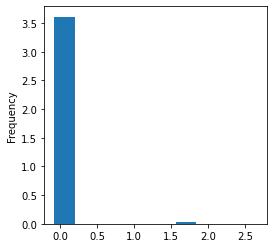

ArchiveYear
Skew : -0.65


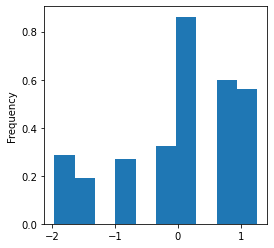

CrewsInvolved
Skew : 5.89


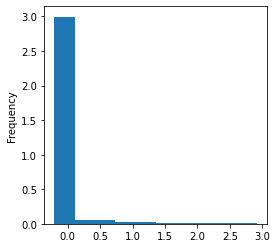

Dozers
Skew : 10.31


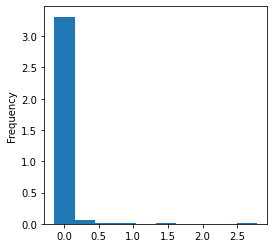

Engines
Skew : 6.2


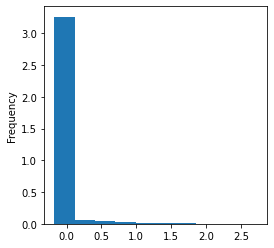

Fatalities
Skew : 28.29


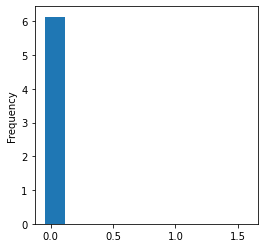

Helicopters
Skew : 10.16


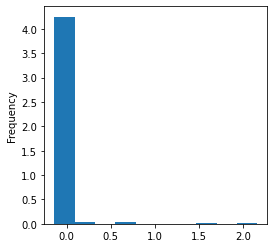

Injuries
Skew : 5.61


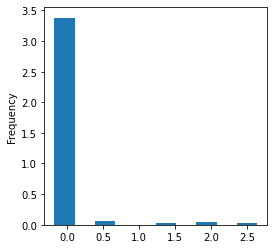

Latitude
Skew : -2.58


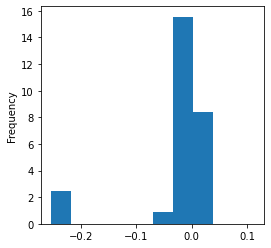

Longitude
Skew : 2.84


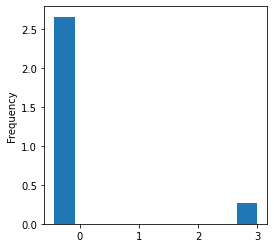

PersonnelInvolved
Skew : 6.37


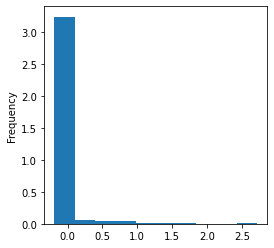

StructuresDamaged
Skew : 15.39


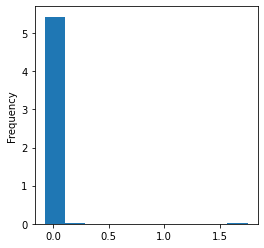

StructuresDestroyed
Skew : 16.14


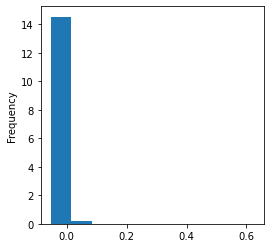

StructuresThreatened
Skew : 31.88


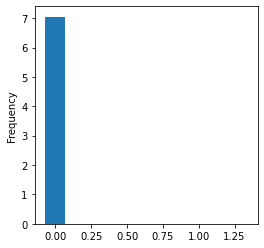

WaterTenders
Skew : 6.92


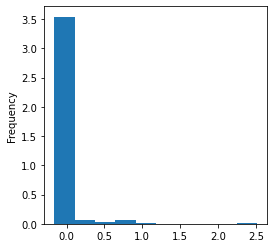

FireTime
Skew : 0.72


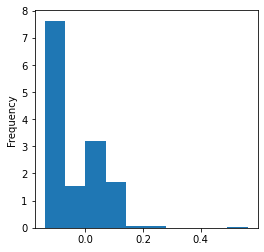

In [7]:
# Checking data for skew
import matplotlib.pyplot as plt
for col in scaled_data_cali:
    print(col)
    print('Skew :',round(scaled_data_cali[col].skew(),2))
    plt.figure(figsize = (4,4))
    scaled_data_cali[col].plot.hist(xlabel = col, density = True)
    plt.show()

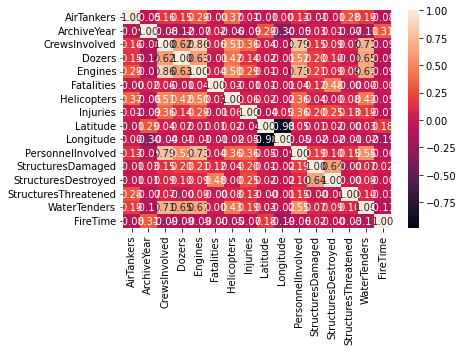

,AirTankers,ArchiveYear,CrewsInvolved,Dozers,Fatalities,Helicopters,Injuries,Latitude,Longitude,StructuresDamaged,StructuresDestroyed,StructuresThreatened,WaterTenders,FireTime
0,-0.079805,-1.969318,0.731945,-0.138297,-0.047557,-0.139214,-0.181899,0.000627,-0.376635,-0.077236,-0.050739,-0.07514,0.456128,-0.139009
1,-0.079805,0.726232,-0.206974,-0.138297,-0.047557,-0.139214,-0.181899,0.010607,-0.317999,-0.077236,-0.052552,-0.07514,-0.162126,0.123858
2,-0.079805,0.187122,-0.206974,-0.138297,-0.047557,-0.139214,-0.181899,-0.029773,-0.244078,-0.077236,-0.052552,-0.07514,-0.162126,0.124688
3,-0.079805,0.187122,-0.206974,-0.138297,-0.047557,-0.139214,-0.181899,0.009704,-0.372928,-0.077236,-0.052552,-0.07514,-0.162126,0.041066
4,-0.079805,0.726232,-0.206974,-0.138297,-0.047557,-0.139214,-0.181899,0.012547,-0.375663,-0.077236,-0.009041,-0.07514,-0.162126,0.063193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,-0.079805,0.726232,-0.206974,-0.138297,-0.047557,-0.139214,-0.181899,-0.012782,-0.344788,-0.077236,-0.052552,-0.07514,-0.162126,-0.022873
1304,-0.079805,0.726232,-0.206974,-0.138297,-0.047557,-0.139214,-0.181899,-0.017212,-0.339142,-0.077236,-0.052552,-0.07514,-0.162126,0.033690
1305,-0.079805,0.187122,-0.206974,-0.138297,-0.047557,-0.139214,-0.181899,0.012377,-0.376908,-0.077236,-0.052552,-0.07514,-0.162126,0.031813
1306,-0.079805,1.265342,-0.206974,-0.138297,-0.047557,-0.139214,-0.181899,-0.003827,-0.363697,-0.077236,-0.052552,-0.07514,-0.162126,-0.140930


In [8]:
# Checking for highly corellated data and removing accordingly
import seaborn as sns
sns.heatmap(scaled_data_cali.corr(), annot=True, fmt='0.2f')
plt.show()
corr = scaled_data_cali.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.75:
            if columns[j]:
                columns[j] = False
# Removing highly correlated columns
selected_columns = scaled_data_cali.columns[columns]
scaled_data_cali = scaled_data_cali[selected_columns]
X_test_s_cali = X_test_s_cali[selected_columns]
scaled_data_cali

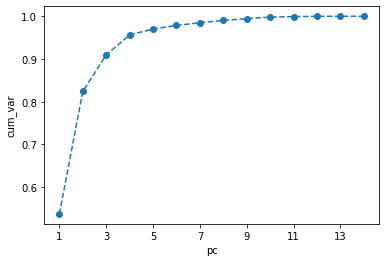

In [9]:
# PC on skew corrected data
from sklearn.decomposition import PCA
n=scaled_data_cali.shape[1]
pca = PCA(n_components=n, random_state=1)
data_pca1 = pd.DataFrame(pca.fit_transform(scaled_data_cali))
exp_var = pca.explained_variance_ratio_
pca_var_explain = pd.DataFrame({'pc': [str(i) for i in range(1,n+1)], 'cum_var': pca.explained_variance_ratio_.cumsum()})
pca_var_explain.plot(kind = "line", x = "pc", 
                     y = "cum_var", 
                     legend = False, 
                     ylabel="cum_var", 
                     marker = 'o', 
                     linestyle = '--')
plt.show()

In [10]:
# Random Forest Method to determine most important features. Will keep top 4 features based on the PCA analysis 
grid_search = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 500]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = grid_search, 
                          cv = 3, n_jobs = -1, verbose = 0)
grid_search.fit(scaled_data_cali, y_train_cali)
rf_clf = RandomForestClassifier()
preds = rf_clf.fit(scaled_data_cali, y_train_cali).predict_proba(X_test_s_cali) 
best_grid_search = grid_search.best_estimator_
best_grid_search.feature_importances_
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_grid_search, X_test_s_cali, y_test_cali)
sorted_idx = perm_importance.importances_mean.argsort()

,FireTime,Latitude,Longitude,StructuresThreatened,StructuresDestroyed,WaterTenders
0,0.112293,-0.008737,-0.337515,-0.07514,-0.052552,-0.162126
1,-0.140930,-0.014111,-0.330388,-0.07514,-0.052552,-0.162126
2,0.041895,-0.003103,-0.331035,-0.07514,-0.052552,-0.162126
3,-0.139795,-0.253278,2.996768,-0.07514,-0.052552,-0.162126
4,-0.140930,-0.001597,-0.374820,-0.07514,-0.052552,-0.162126
...,...,...,...,...,...,...
323,0.047394,0.015477,-0.374525,-0.07514,-0.052552,-0.162126
324,-0.132419,-0.012683,-0.356737,-0.07514,-0.016293,-0.162126
325,-0.137133,0.021180,-0.337830,-0.07514,-0.052552,0.662213
326,-0.133729,-0.007419,-0.299767,-0.07514,-0.047113,0.250043


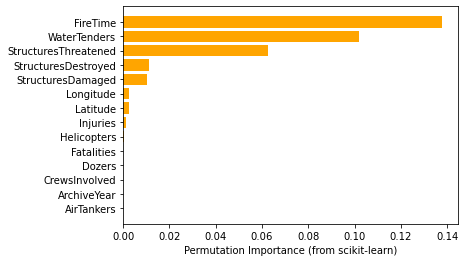

In [11]:
# Plotting the feature importance graph using random forest method
plt.barh(scaled_data_cali.columns, perm_importance.importances_mean[sorted_idx], color = "orange")
plt.xlabel("Permutation Importance (from scikit-learn)")
selected_columns = [
    'FireTime',
    'Latitude',
    'Longitude',
    'StructuresThreatened',
    'StructuresDestroyed',
    'WaterTenders'
]
# removing the non highly important features. Keeping top 6 features as it proves important.
scaled_data_cali_rf = scaled_data_cali[selected_columns].copy()
x_test_cali_rf = X_test_s_cali[selected_columns].copy()
x_test_cali_rf

Now we move on to setting up our data set from portugal and finding the most important features. We will also use the same techniques as a bove to normalize and trim out unnecessary data.

In [12]:
portugal_fire_data = pd.read_csv('forestfires.csv')
portugal_fire_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [13]:
# Portugal Fire Analysis
# Convert the month and week column to numerical values for model to parse.
portugal_fire_data.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),(1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
portugal_fire_data.replace(('mon','tue','wed','thu','fri','sat','sun'),(1,2,3,4,5,6,7), inplace=True)
portugal_fire_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    int64  
 3   day     517 non-null    int64  
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(5)
memory usage: 52.6 KB


In [14]:
# splitting into train and test
X_port = portugal_fire_data.drop('area', axis=1)
y_port = portugal_fire_data['area']
X_train_port, X_test_port, y_train_port, y_test_port = train_test_split(X_port, y_port, test_size=.20, random_state = 42)
y_train_port

329     3.33
173     3.07
272     3.09
497    14.68
182     6.38
       ...  
71      0.00
106     0.00
270     0.52
435     0.00
102     0.00
Name: area, Length: 413, dtype: float64

In [15]:
# Scaling data to be processed
s = StandardScaler()
scaled_data_port = pd.DataFrame(s.fit_transform(X_train_port))
X_test_s_port = pd.DataFrame(s.transform(X_test_port), columns=X_test_port.columns)
scaled_data_port.columns = X_train_port.columns
scaled_data_port
X_test_nm_port = X_test_s_port

In [16]:
# Getting rid of outliers
scaled_data_port[scaled_data_port >= 3] = np.nan
scaled_data_port[scaled_data_port <= -3] = np.nan
scaled_data_port.dropna(how = 'any', axis = 'rows', inplace = True)
# trimming y_train rows to match the number of rows on feature matrix
list = []
list = scaled_data_port.index
y_train_port = pd.DataFrame(y_train_port)
y_train_nm_port = pd.DataFrame(y_train_port)
y_train_port = y_train_port.iloc[list, :]
scaled_data_port

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,-0.288472,-1.094859,0.669844,0.843134,0.280286,-0.150282,0.810272,-0.095838,0.797602,-1.059419,0.001631,-0.067817
1,-0.288472,-0.266696,0.669844,-1.532134,0.061652,0.217866,0.549136,-0.455434,-0.205272,-0.335215,-1.008923,-0.067817
2,-1.161285,0.561466,0.230026,-1.057080,0.263468,0.614919,0.435442,1.419602,0.227001,0.147588,0.001631,-0.067817
3,-0.724878,-0.266696,0.230026,-1.057080,0.936186,1.048482,0.487669,1.419602,2.319206,-1.059419,-1.008923,-0.067817
4,0.147934,-0.266696,-2.408881,1.318187,-0.627884,-1.469227,-2.014816,-1.251682,-1.121692,0.509690,-1.008923,-0.067817
...,...,...,...,...,...,...,...,...,...,...,...,...
408,-0.288472,0.561466,0.669844,0.368080,0.633463,-0.411941,0.572437,1.830569,-0.205272,-0.455916,-0.222936,-0.067817
409,-0.288472,0.561466,-1.969064,-0.106973,0.145742,-1.239514,-1.910361,-0.327007,-0.118818,-0.938719,-0.503646,-0.067817
410,-1.161285,-1.923022,0.230026,-1.057080,0.263468,0.614919,0.435442,1.419602,0.503656,0.690741,-0.503646,-0.067817
411,-1.161285,0.561466,-0.209792,0.843134,0.044834,-0.418026,-0.695879,-0.815030,0.849475,0.388990,-1.233490,-0.067817


X
Skew : 0.08


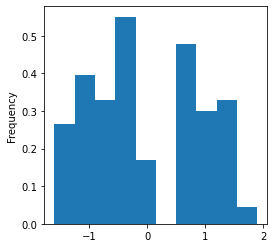

Y
Skew : -0.2


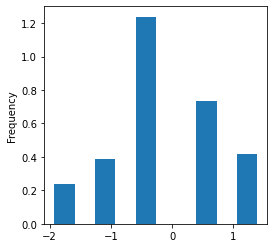

month
Skew : -1.3


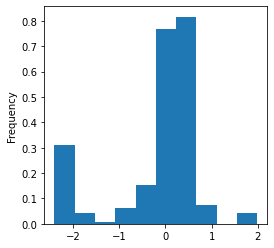

day
Skew : -0.18


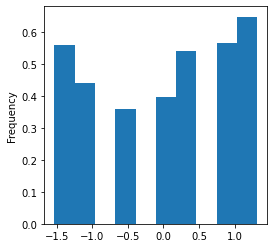

FFMC
Skew : -1.74


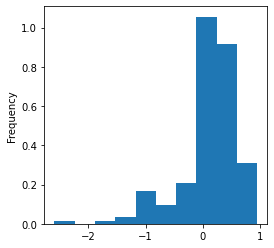

DMC
Skew : 0.6


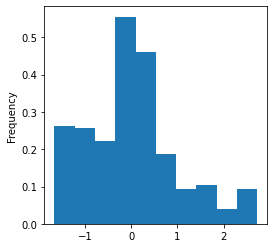

DC
Skew : -1.18


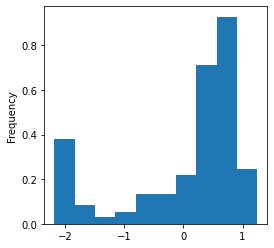

ISI
Skew : 0.6


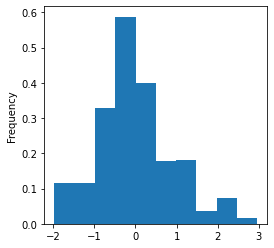

temp
Skew : -0.27


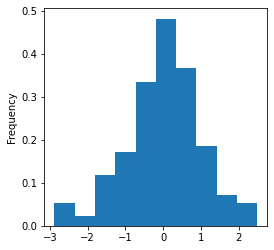

RH
Skew : 0.69


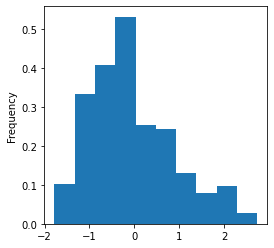

wind
Skew : 0.48


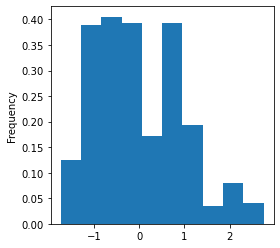

rain
Skew : 14.94


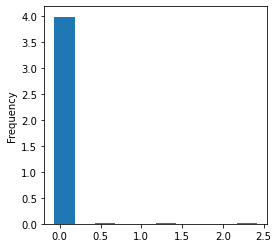

In [17]:
# Checking data for skew
import matplotlib.pyplot as plt
for col in scaled_data_port:
    print(col)
    print('Skew :',round(scaled_data_port[col].skew(),2))
    plt.figure(figsize = (4,4))
    scaled_data_port[col].plot.hist(xlabel = col, density = True)
    plt.show()

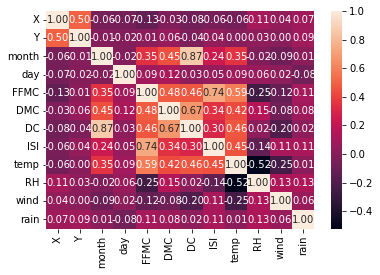

,X,Y,month,day,FFMC,DMC,ISI,temp,RH,wind,rain
0,-0.288472,-1.094859,0.669844,0.843134,0.280286,-0.150282,-0.095838,0.797602,-1.059419,0.001631,-0.067817
1,-0.288472,-0.266696,0.669844,-1.532134,0.061652,0.217866,-0.455434,-0.205272,-0.335215,-1.008923,-0.067817
2,-1.161285,0.561466,0.230026,-1.057080,0.263468,0.614919,1.419602,0.227001,0.147588,0.001631,-0.067817
3,-0.724878,-0.266696,0.230026,-1.057080,0.936186,1.048482,1.419602,2.319206,-1.059419,-1.008923,-0.067817
4,0.147934,-0.266696,-2.408881,1.318187,-0.627884,-1.469227,-1.251682,-1.121692,0.509690,-1.008923,-0.067817
...,...,...,...,...,...,...,...,...,...,...,...
408,-0.288472,0.561466,0.669844,0.368080,0.633463,-0.411941,1.830569,-0.205272,-0.455916,-0.222936,-0.067817
409,-0.288472,0.561466,-1.969064,-0.106973,0.145742,-1.239514,-0.327007,-0.118818,-0.938719,-0.503646,-0.067817
410,-1.161285,-1.923022,0.230026,-1.057080,0.263468,0.614919,1.419602,0.503656,0.690741,-0.503646,-0.067817
411,-1.161285,0.561466,-0.209792,0.843134,0.044834,-0.418026,-0.815030,0.849475,0.388990,-1.233490,-0.067817


In [18]:
# Checking for highly corellated data and removing accordingly
sns.heatmap(scaled_data_port.corr(), annot=True, fmt='0.2f')
plt.show()
corr = scaled_data_port.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.75:
            if columns[j]:
                columns[j] = False
selected_columns = scaled_data_port.columns[columns]
scaled_data_port = scaled_data_port[selected_columns]
X_test_s_port = X_test_s_port[selected_columns]
scaled_data_port

In [19]:
# Creating a pipeline to normalize the data
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
proc_pipe = Pipeline(steps = [("yeo-jhonson", PowerTransformer(method='yeo-johnson')), ('scale',StandardScaler())])
X_train_proc = pd.DataFrame(proc_pipe.fit_transform(X_train_port),columns=X_train_port.columns)
X_test_proc = pd.DataFrame(proc_pipe.fit_transform(X_test_port),columns=X_test_port.columns)

X
Skew : -0.12


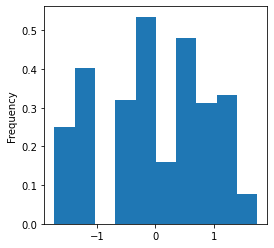

Y
Skew : 0.03


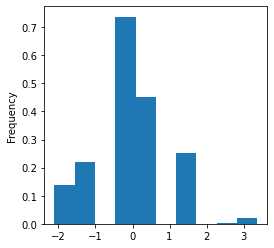

month
Skew : -0.23


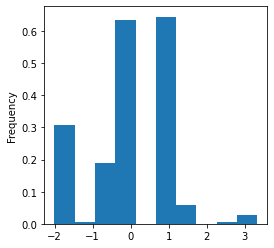

day
Skew : -0.22


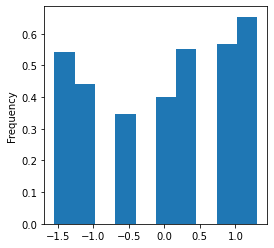

FFMC
Skew : -0.3


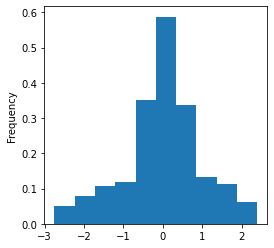

DMC
Skew : -0.09


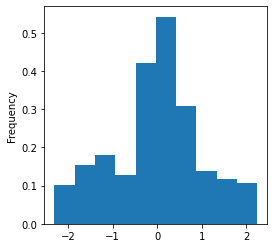

DC
Skew : -0.86


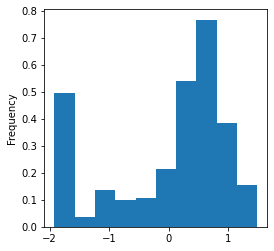

ISI
Skew : 0.04


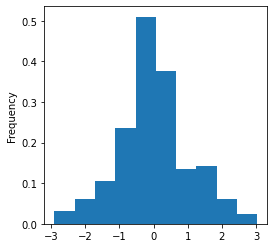

temp
Skew : -0.03


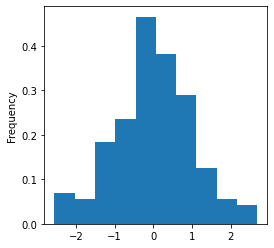

RH
Skew : 0.0


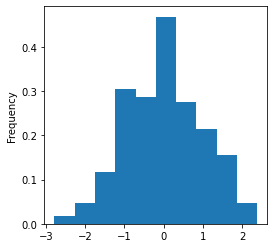

wind
Skew : -0.02


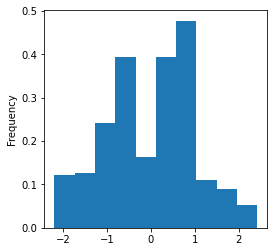

rain
Skew : 8.14


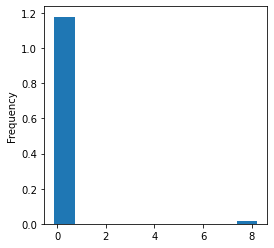

In [20]:
# Look at corrected plots. As it can be seen. We have succesfully normalized the data using a pipeline.
import matplotlib.pyplot as plt
for col in X_train_proc:
    print(col)
    print('Skew :',round(X_train_proc[col].skew(),2))
    plt.figure(figsize = (4,4))
    X_train_proc[col].plot.hist(xlabel = col, density = True)
    plt.show()

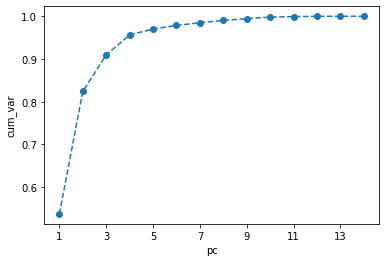

In [23]:
# PC on skew corrected data
from sklearn.decomposition import PCA
m=scaled_data_port.shape[1]
pca_skew = PCA(n_components=m, random_state=1)
data_pca1 = pd.DataFrame(pca_skew.fit_transform(X_train_proc))
exp_var = pca.explained_variance_ratio_
pca_var_explain = pd.DataFrame({'pc': [str(i) for i in range(1,n+1)], 'cum_var': pca.explained_variance_ratio_.cumsum()})
pca_var_explain.plot(kind = "line", x = "pc", 
                     y = "cum_var", 
                     legend = False, 
                     ylabel="cum_var", 
                     marker = 'o', 
                     linestyle = '--')
plt.show()

Text(0.5, 0, 'Permutation Importance (from scikit-learn)')

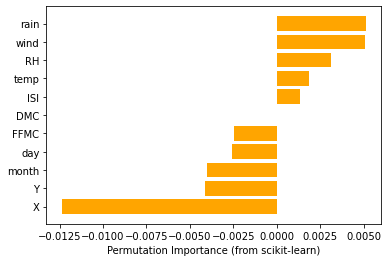

In [24]:
# Random Forest Method to determine most important features. Will keep top 6 features based on the PCA analysis 
grid_search = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 500]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = grid_search, 
                          cv = 3, n_jobs = -1, verbose = 0)
grid_search.fit(scaled_data_port, y_train_port)
best_grid_search = grid_search.best_estimator_
best_grid_search.feature_importances_
perm_importance = permutation_importance(best_grid_search, X_test_s_port, y_test_port)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(scaled_data_port.columns, perm_importance.importances_mean[sorted_idx], color = "orange")
plt.xlabel("Permutation Importance (from scikit-learn)")

In [25]:
# Random Forest Method to determine most important features. Will keep top 6 features based on the PCA analysis
selected_columns = [
    'rain',
    'wind',
    'RH',
    'temp',
    'ISI',
    'DMC'
]
scaled_data_port_rf = scaled_data_port[selected_columns].copy()
x_test_port_rf = X_test_s_port[selected_columns].copy()
x_test_port_rf

,rain,wind,RH,temp,ISI,DMC
0,-0.067817,0.506908,2.984055,-1.311893,-1.354424,-1.280589
1,2.421824,0.506908,1.233895,0.469074,1.419602,1.048482
2,-0.067817,-1.233490,-0.938719,1.143421,-0.147209,1.442492
3,-0.067817,0.506908,0.147588,0.209710,1.830569,-0.411941
4,-0.067817,0.506908,-0.878368,1.783186,2.883671,0.414111
...,...,...,...,...,...,...
99,-0.067817,0.282341,-0.697317,0.780311,1.984681,0.226994
100,-0.067817,0.506908,0.992493,-2.383931,-1.739706,-1.304929
101,4.289054,2.022739,1.595997,0.382620,-0.429749,0.832461
102,-0.067817,1.012185,1.595997,0.520947,-1.765391,-0.843983


We essentially started with the claifornia dataset. We first split the dataset into the train and test columns. We then looked at the outliers in the dataset and removed them. Next, we plotted the dataset to understand the skew and corrected for it. Finally, we wanted to figure out the optimal number of features and the most important features. We completed PCA to figure out the number of features when fitting the data. Next we used random forest to figure out the optimal number of features. I then created a new array with just these features. This process was repeated on the Portugal dataset as well.

# Results (10 points)

Fit your model(s) here, optimize, and finally report the validation statisitcs. Use comments `#` where relevant to clarify the steps.

In [26]:
# Using a bayesian model first to fit the data for both California and Portugal Datasets
from sklearn.metrics import mean_absolute_error
from hpsklearn import HyperoptEstimator
from hpsklearn import any_regressor
from hpsklearn import any_preprocessing
from hyperopt import tpe

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [27]:
# Create Bayesian Model for Cali wildfire data
model = HyperoptEstimator(regressor=any_regressor('reg'), preprocessing=any_preprocessing('pre'), loss_fn=mean_absolute_error, algo=tpe.suggest, max_evals=50, trial_timeout=30)

In [28]:
# Fit the model for Cali wildfire data
model.fit(scaled_data_cali_rf, y_train_cali)
print(model.best_model())

100%|██████████| 50/50 [00:02<00:00,  2.71s/trial, best loss: 2789.9847691916502]
{'learner': GradientBoostingRegressor(alpha=0.8551423779686803,
                          learning_rate=0.0359934991080926, loss='huber',
                          max_depth=None, max_features=0.6056315313013924,
                          min_samples_leaf=6, n_estimators=50, random_state=0,
                          subsample=0.9097298222662141), 'preprocs': (), 'ex_preprocs': ()}


In [29]:
# Create and fit the model for the portugal wildfire data
model_port = HyperoptEstimator(regressor=any_regressor('reg'), preprocessing=any_preprocessing('pre'), loss_fn=mean_absolute_error, algo=tpe.suggest, max_evals=50, trial_timeout=30)
model_port.fit(scaled_data_port_rf, y_train_port)
print(model_port.best_model())

100%|██████████| 50/50 [00:26<00:00, 26.90s/trial, best loss: 7.3686323865192955]
{'learner': GradientBoostingRegressor(learning_rate=0.08068429029435582, loss='lad',
                          max_depth=2, max_features='log2', min_samples_leaf=2,
                          n_estimators=200, random_state=1,
                          subsample=0.9539368525975164), 'preprocs': (), 'ex_preprocs': ()}


In [30]:
mae_cali = model.score(x_test_cali_rf, y_test_cali)
print('R2 score for Bayesian Regression Model on Cali Data: ', mae_cali)
mae_port = model_port.score(x_test_port_rf, y_test_port)
print('R2 score for Bayesian Regression Model on Portugal Data: ', mae_port)

R2 score for Bayesian Regression Model on Cali Data:  0.07739288016940371
R2 score for Bayesian Regression Model on Portugal Data:  -0.026790531401285733


It is clear that we can improve this by choosing a new model. We will choose Random forest and apply Grid search tuning techniques on it.

In [31]:
# import
from sklearn.model_selection import GridSearchCV
# Random forest regressor for cali data
rf = RandomForestRegressor()
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# the max number of levels or layers in a tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# to split nodes, the minimum number of samples
min_samples_split = [2, 5, 10]
# to be a leaf (terminal node), the minimum number of samples
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
rf.fit(scaled_data_cali_rf, y_train_cali)
print('Random Forest without Tuning for Cali Data: ', rf.score(x_test_cali_rf, y_test_cali))
grid_search = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 500]
}

rf2 = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf2, param_grid = grid_search, 
                          cv = 3, n_jobs = -1, verbose = 0)
grid_search.fit(scaled_data_cali_rf, y_train_cali)
best_grid_search = grid_search.best_estimator_
grid_search_R2 = best_grid_search.score(x_test_cali_rf, y_test_cali)
print('Random Forestwith Grid Search Tuning for Cali Data: ', grid_search_R2)

Random Forest without Tuning for Cali Data:  0.19647885923328756
Random Forestwith Grid Search Tuning for Cali Data:  0.16961883529371613


In [28]:
# Now applying it on Portugal Data data
rf = RandomForestRegressor()
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# the max number of levels or layers in a tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# to split nodes, the minimum number of samples
min_samples_split = [2, 5, 10]
# to be a leaf (terminal node), the minimum number of samples
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
rf.fit(scaled_data_port_rf, y_train_port)
print('Random Forest without Tuning for Portugal Data: ', rf.score(x_test_port_rf, y_test_port))
grid_search = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 500]
}

rf2 = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf2, param_grid = grid_search, 
                          cv = 3, n_jobs = -1, verbose = 0)
grid_search.fit(scaled_data_port_rf, y_train_port)
best_grid_search = grid_search.best_estimator_
grid_search_R2 = best_grid_search.score(x_test_port_rf, y_test_port)
print('Random Forestwith Grid Search Tuning for Portugal Data: ', grid_search_R2)

Random Forest without Tuning for Portugal Data:  -0.013173496101323234
Random Forestwith Grid Search Tuning for Portugal Data:  0.0023158340598185


In [65]:
# Random forest even when tuned did not show good results. We can try neural networks if they can learn better.
# import necessary libraries to run NN 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_regression
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU 
from keras.metrics import AUC
from keras import backend as K
tf.random.set_seed(42)
K.clear_session()

In [66]:
# We are going to run a NN with regularization from the padding. We will set our own R2 scale
model_2 = Sequential()
model_2.add(Dense(128, activation=LeakyReLU(alpha=0.01), input_shape=(scaled_data_cali_rf.shape[1],)))
model_2.add(Dropout(0.1))
model_2.add(Dense(64, activation=LeakyReLU(alpha=0.01)))
model_2.add(Dropout(0.1))
model_2.add(Dense(32, activation=LeakyReLU(alpha=0.01)))
model_2.add(Dense(1, activation='linear'))
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
model_2.compile(loss = 'mean_squared_error', optimizer='adamax', metrics=[r2])
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               896       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
____________________________________________________

In [73]:
# Run the NN on the california dataset
model_2_reg_perf = model_2.fit(scaled_data_cali_rf, 
                    y_train_cali.values, 
                    validation_split=0.1, 
                    epochs=100, 
                    verbose=2)

Epoch 1/100
35/35 - 0s - loss: 168397232.0000 - r2: -1.1382e-01 - val_loss: 128855568.0000 - val_r2: -1.3376e-01
Epoch 2/100
35/35 - 0s - loss: 168377296.0000 - r2: -1.0761e-01 - val_loss: 128832544.0000 - val_r2: -1.3188e-01
Epoch 3/100
35/35 - 0s - loss: 168350448.0000 - r2: -1.3386e-01 - val_loss: 128806184.0000 - val_r2: -1.2972e-01
Epoch 4/100
35/35 - 0s - loss: 168322832.0000 - r2: -1.1111e-01 - val_loss: 128770024.0000 - val_r2: -1.2676e-01
Epoch 5/100
35/35 - 0s - loss: 168283472.0000 - r2: -9.0803e-02 - val_loss: 128727208.0000 - val_r2: -1.2327e-01
Epoch 6/100
35/35 - 0s - loss: 168239088.0000 - r2: -1.0717e-01 - val_loss: 128681128.0000 - val_r2: -1.1950e-01
Epoch 7/100
35/35 - 0s - loss: 168183104.0000 - r2: -1.0420e-01 - val_loss: 128622608.0000 - val_r2: -1.1483e-01
Epoch 8/100
35/35 - 0s - loss: 168125904.0000 - r2: -8.7785e-02 - val_loss: 128559520.0000 - val_r2: -1.0981e-01
Epoch 9/100
35/35 - 0s - loss: 168052480.0000 - r2: -9.0581e-02 - val_loss: 128484168.0000 - val

Epoch 73/100
35/35 - 0s - loss: 162747296.0000 - r2: -6.8581e+00 - val_loss: 123322800.0000 - val_r2: -1.4686e+00
Epoch 74/100
35/35 - 0s - loss: 162710784.0000 - r2: -4.3020e+00 - val_loss: 123306696.0000 - val_r2: -1.4908e+00
Epoch 75/100
35/35 - 0s - loss: 162607728.0000 - r2: -7.8568e-01 - val_loss: 123289832.0000 - val_r2: -1.4909e+00
Epoch 76/100
35/35 - 0s - loss: 162712048.0000 - r2: -1.6991e+00 - val_loss: 123276632.0000 - val_r2: -1.4937e+00
Epoch 77/100
35/35 - 0s - loss: 162563600.0000 - r2: -2.6571e+00 - val_loss: 123263032.0000 - val_r2: -1.5190e+00
Epoch 78/100
35/35 - 0s - loss: 162830064.0000 - r2: -1.3631e+00 - val_loss: 123245248.0000 - val_r2: -1.5214e+00
Epoch 79/100
35/35 - 0s - loss: 162737456.0000 - r2: -1.1665e+00 - val_loss: 123229200.0000 - val_r2: -1.5335e+00
Epoch 80/100
35/35 - 0s - loss: 162881392.0000 - r2: -2.6520e+00 - val_loss: 123210440.0000 - val_r2: -1.5064e+00
Epoch 81/100
35/35 - 0s - loss: 162840352.0000 - r2: -1.9936e+00 - val_loss: 123196488.0

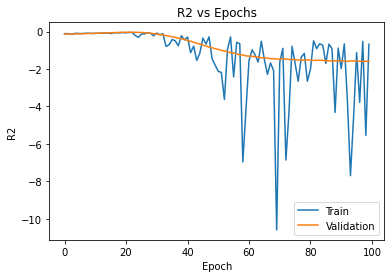

-0.011453165074577942

In [74]:
# Plot the results
plt.plot(model_2_reg_perf.history['r2'])
plt.plot(model_2_reg_perf.history['val_r2'])
plt.title('R2 vs Epochs')
plt.ylabel('R2')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
metrics.r2_score(y_test_cali.values, model_2.predict(x_test_cali_rf).flatten())

In [69]:
tf.random.set_seed(42)
K.clear_session()

In [70]:
# Set up the NN for the portugal dataset
model_2 = Sequential()
model_2.add(Dense(128, activation=LeakyReLU(alpha=0.01), input_shape=(scaled_data_port_rf.shape[1],)))
model_2.add(Dropout(0.1))
model_2.add(Dense(64, activation=LeakyReLU(alpha=0.01)))
model_2.add(Dropout(0.1))
model_2.add(Dense(32, activation=LeakyReLU(alpha=0.01)))
model_2.add(Dense(1, activation='linear'))
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
model_2.compile(loss = 'mean_squared_error', optimizer='adamax', metrics=[r2])
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               896       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
____________________________________________________

In [71]:
# Run the NN for the portugal dataset
model_2_reg_perf = model_2.fit(scaled_data_port_rf, 
                    y_train_port.values, 
                    validation_split=0.1, 
                    epochs=100, 
                    verbose=2)

Epoch 1/100
11/11 - 1s - loss: 2348.7368 - r2: -1.7345e-01 - val_loss: 1221.2623 - val_r2: -9.0132e-02
Epoch 2/100
11/11 - 0s - loss: 2344.1221 - r2: -1.6578e-01 - val_loss: 1218.0580 - val_r2: -5.7002e-02
Epoch 3/100
11/11 - 0s - loss: 2339.4717 - r2: -1.6532e-01 - val_loss: 1215.1376 - val_r2: -2.9542e-02
Epoch 4/100
11/11 - 0s - loss: 2335.8313 - r2: -1.5484e-01 - val_loss: 1211.5768 - val_r2: -3.7937e-03
Epoch 5/100
11/11 - 0s - loss: 2330.0417 - r2: -1.4567e-01 - val_loss: 1208.1296 - val_r2: 0.0161
Epoch 6/100
11/11 - 0s - loss: 2325.9766 - r2: -1.3960e-01 - val_loss: 1204.1080 - val_r2: 0.0309
Epoch 7/100
11/11 - 0s - loss: 2320.5591 - r2: -1.2381e-01 - val_loss: 1199.7750 - val_r2: 0.0370
Epoch 8/100
11/11 - 0s - loss: 2315.2190 - r2: -1.1648e-01 - val_loss: 1194.7896 - val_r2: 0.0248
Epoch 9/100
11/11 - 0s - loss: 2307.1838 - r2: -9.4477e-02 - val_loss: 1190.2902 - val_r2: -4.4185e-03
Epoch 10/100
11/11 - 0s - loss: 2302.0613 - r2: -8.5034e-02 - val_loss: 1185.4626 - val_r2: -

11/11 - 0s - loss: 2161.2302 - r2: -7.5986e-01 - val_loss: 1101.0764 - val_r2: -4.9556e+00
Epoch 81/100
11/11 - 0s - loss: 2156.8674 - r2: -2.5836e-01 - val_loss: 1100.4033 - val_r2: -4.9664e+00
Epoch 82/100
11/11 - 0s - loss: 2175.9363 - r2: -2.3674e+00 - val_loss: 1099.4930 - val_r2: -4.8628e+00
Epoch 83/100
11/11 - 0s - loss: 2163.2048 - r2: -1.7283e-01 - val_loss: 1098.6235 - val_r2: -4.8206e+00
Epoch 84/100
11/11 - 0s - loss: 2156.2756 - r2: -6.4833e-01 - val_loss: 1098.0847 - val_r2: -4.7588e+00
Epoch 85/100
11/11 - 0s - loss: 2163.8206 - r2: -1.6967e-01 - val_loss: 1097.3206 - val_r2: -4.7526e+00
Epoch 86/100
11/11 - 0s - loss: 2166.3232 - r2: -4.9982e-01 - val_loss: 1096.4371 - val_r2: -4.6527e+00
Epoch 87/100
11/11 - 0s - loss: 2154.4639 - r2: -2.5833e-01 - val_loss: 1095.9880 - val_r2: -4.5339e+00
Epoch 88/100
11/11 - 0s - loss: 2161.7754 - r2: -4.4605e-01 - val_loss: 1095.3625 - val_r2: -4.6498e+00
Epoch 89/100
11/11 - 0s - loss: 2161.9314 - r2: -6.4344e-01 - val_loss: 1094.

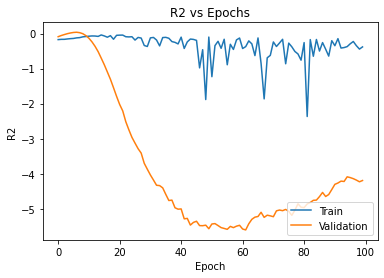

0.002168047752031277

In [72]:
# Plot the data
plt.plot(model_2_reg_perf.history['r2'])
plt.plot(model_2_reg_perf.history['val_r2'])
plt.title('R2 vs Epochs')
plt.ylabel('R2')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
metrics.r2_score(y_test_port.values, model_2.predict(x_test_port_rf).flatten())

We can see that from these models, the portugal data had no clear trends to predicting burn area based on its features. On the other hand, the california wild fires do have some features but the correlation is very bad. It can be safely said that with the given data features, training a ML model to predict the area that a wildfire is going to burn is much more complicated and needs better data and better ML methods. Even the NN model that incorporated Regularization within had no success. From the given models, the Random forest model was the best model for predicting the burned area. Of the two datasets, the california dataset were the better one to predict burned area. Now we can move onto the classification problem of predicting the confidence that a wildfire will take place. This data set has many features such as wind, moisture content, soil content, weather, nearby water masses and more to predict the likelihood of a fire to take place. The multiclass classification problem is going to be split into 3 categories. The first category is very unlikely, second is somewhat likely and third is likely. We will split the Y dataset to represent this and then remove non important features. Finally we will train an ML model to see if we get any better results. 

In [88]:
# Setup and read the dataset for the multiclass confidence problem
conf_data = pd.read_csv("covtype.csv")
conf_data.info()
y = conf_data['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(conf_data, y, test_size=.20, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [89]:
# Tranform dataset
s = MinMaxScaler()

X_train_reg_s = s.fit_transform(X_train) 
X_test_reg_s = s.transform(X_test) 

In [90]:
tf.random.set_seed(42)
K.clear_session()

Split the dataset into its classes. Essentially, greater than 6 is a certain chance of fire, 2-6 is a chance fore fire and less than two is no chance.

In [92]:
# SPlit classes
y_train_mc = y_train.apply(lambda x: np.where(x >= 6, 2, np.where(x < 6 and x > 2, 1, 0)))
y_test_mc = y_test.apply(lambda x: np.where(x >= 6, 2, np.where(x < 6 and x > 2, 1, 0)))
y_train_mc.value_counts()

0    396084
1     38352
2     30373
Name: Cover_Type, dtype: int64

In [93]:
y_train_multiclass = tf.keras.utils.to_categorical(y_train_mc.values, num_classes=3)
y_train_multiclass = tf.one_hot(y_train_mc, depth=3)
y_test_multiclass = tf.one_hot(y_test_mc, depth=3)

In [94]:
# Create The model
model_mc = Sequential()
model_mc.add(Dense(128, activation='relu', input_shape=(X_train_reg_s.shape[1], )))
model_mc.add(Dropout(0.1))
model_mc.add(Dense(64, activation='relu'))
model_mc.add(Dropout(0.1))
model_mc.add(Dense(3, activation='softmax'))

In [95]:
model_mc.compile(loss = "categorical_crossentropy", optimizer='adam', metrics=['accuracy', AUC(multi_label = True)])
model_mc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               7168      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 15,619
Trainable params: 15,619
Non-trainable params: 0
_________________________________________________________________


In [97]:
# Run the model
multi_class = model_mc.fit(X_train_reg_s, 
                    y_train_multiclass,
                    validation_split=0.1, 
                    epochs=10, 
                    verbose=2)

Epoch 1/10
13073/13073 - 26s - loss: 1.0616e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 7.0529e-10 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 2/10
13073/13073 - 27s - loss: 3.0298e-04 - accuracy: 0.9999 - auc: 1.0000 - val_loss: 1.0154e-08 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 3/10
13073/13073 - 27s - loss: 1.1696e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 9.1098e-09 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 4/10
13073/13073 - 30s - loss: 1.1633e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 6.6706e-04 - val_accuracy: 0.9996 - val_auc: 1.0000
Epoch 5/10
13073/13073 - 29s - loss: 1.1592e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.5852e-09 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 6/10
13073/13073 - 29s - loss: 6.3510e-05 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0776e-11 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 7/10
13073/13073 - 28s - loss: 2.4086e-04 - accuracy: 0.9999 - auc: 1.0000 - val_loss: 1.7120e-08 - val_accuracy: 1.0000 - v

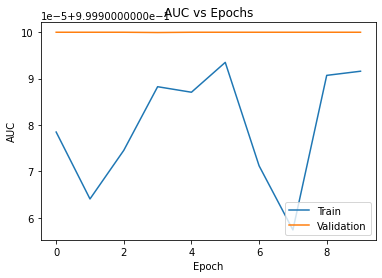

ROC AUC Score for Predicting the liklehood of wildfire:  1.0


In [101]:
#Plot the model
plt.plot(multi_class.history['auc'])
plt.plot(multi_class.history['val_auc'])
plt.title('AUC vs Epochs')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
print('ROC AUC Score for Predicting the liklehood of wildfire: ', metrics.roc_auc_score(y_test_multiclass, model_mc.predict(X_test_reg_s), multi_class='ovo'))

# Conclusions (5 Points)

What can we conclude? Is the model successful? How will it be used? Importantly, what are some limitations that you might need to address going forward?

From this, it can be concluded that the random forest regressor was the best model in predicting the burn area for California. It seemed that the R2 score was around 0.25. Still not a very good predictor. The portugal dataset proved to have no correlation and not predictable to any sort of model. The last part we moved to predicting the confidence of wildfire happening in an area based on some charectistics. We turned the problem into a multiclass classifier problem and us NN to solve. The ROC AUC curve showed a 100% validation rate meaning that this model was very succesfull at predicting the likelihood of a fire happening. Based on the current data and ML algorithms available now, this results make sense. Our algorithms and data available to study and predict the spread of weather routes and hazardous events are at a primal stage. It can be seen that the data out there is not yet mature to safely predict wildfire behavior. Hence, many entrepreneurships are focusing on this very ML task.   

### Bonus (Explainable AI, up to 5 extra points)

In the real world, people are rightfully skeptical when they hear about AI/ML success. Help build confidence in the model's predictions by using tools in the Week 10 Notebook. 